In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft, fftfreq

## Set up code for filters

In [3]:
from scipy.signal import butter, lfilter, freqz, wiener


def butter_lowpass(cutoff, fs, order=5):
    return butter(order, cutoff, fs=fs, btype="low", analog=False)


def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y


def butter_highpass(cutoff, fs, order=5):
    return butter(order, cutoff, fs=fs, btype="high", analog=False)


def butter_highpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [4]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    return butter(order, [lowcut, highcut], fs=fs, btype="bandstop")


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

## FFT utility functions

In [5]:
def getFFT(time, data):

    # time = np.linspace(0, 10, 1000) #test
    # data = np.sin(2*np.pi*time)
    time = time * 1e-6  # us to s
    # FFT of data
    N = len(data)
    T = ((time[-1] - time[0])) / N
    dfft = fft(data)
    return dfft


def plotFFT(time, fft):
    N = len(time)
    T = ((time[-1] - time[0])) / N

    # PLOT
    xf = fftfreq(N, T)[: N // 2]  # only used for correct scale when plotting
    plt.xscale("log")
    plt.yscale("log")
    plt.plot(xf, 2.0 / N * np.abs(fft[0 : N // 2]))
    plt.title("FFT")
    plt.xlabel("Frequency (hz)")
    plt.ylabel("Amplitude")

    plt.show()

## Read data from file

            Time  Channel A  Channel B  Channel C  average(C)  average(B)
0      -4.998000        0.0   0.063423   0.039678   -0.000550    0.041877
1      -4.994000        0.0   0.079232   0.000000    0.000812    0.041951
2      -4.990000        0.0   0.063423   0.039678   -0.000366    0.041710
3      -4.986000        0.0   0.063423   0.039678   -0.000576    0.041574
4      -4.982000        0.0   0.063423   0.000000   -0.000785    0.041668
...          ...        ...        ...        ...         ...         ...
12497  44.989999        0.0   0.000000  -0.039678    0.004532    0.053000
12498  44.993999        0.0   0.031681  -0.079355    0.005579    0.053052
12499  44.997999        0.0   0.063423  -0.119033    0.005082    0.053157
12500  45.001999        0.0   0.095103  -0.119033    0.005474    0.053221
12501  45.005999        0.0   0.110974  -0.158711    0.004086    0.053022

[12502 rows x 6 columns]


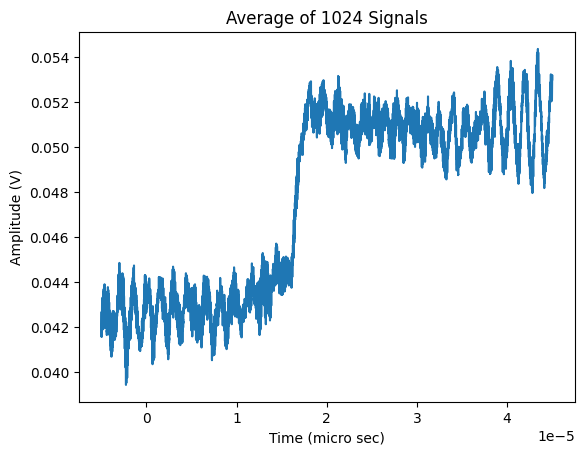

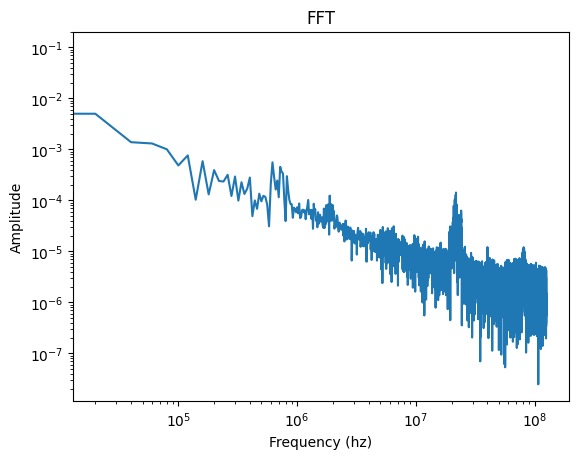

In [26]:
def plotGraphs(time, data, tstfreq=None):
    plt.plot(time, data)
    plt.title("Average of 1024 Signals")
    plt.xlabel("Time (micro sec)")
    plt.ylabel("Amplitude (V)")
    if tstfreq is not None:
        plt.plot(time, 0.005 * np.sin(2 * np.pi * tstfreq * time) + 0.05)
    plt.show()

    dfft = getFFT(time, data)
    plotFFT(time, dfft)


C = 1000
df = pd.read_csv(
    f"./20231110/20231110-L25-C{C}-G0-A100-anode/20231110-L25-C{C}-G0-A100-anode_0001.csv",
    skiprows=[1],
)
print(df)
time = np.asarray(df["Time"]) * 1e-6  # convert to seconds
data = np.asarray(df["average(B)"])
# data = np.asarray(df["Channel B"])
# data = butter_lowpass_filter(data, 1e6, )
plotGraphs(time, data)

plt.plot()

In [27]:
from scipy import signal
from scipy.optimize import curve_fit


def gauss(x, A, mu, sigma):
    return A * np.exp(-0.5 * ((x - mu) / sigma) ** 2)

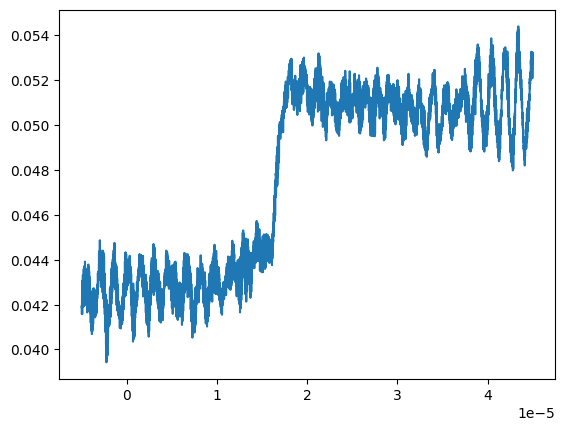

In [28]:
plt.plot(time, data)

## Filtering chain

In [29]:
# define filters
time_s = time
fs = len(data) / (time_s[-1] - time_s[0])


filters = []
labels = []


freq = 3.2
lowpass = lambda data: butter_lowpass_filter(data, freq * 1e6, fs, order=6)
filters.append(lowpass)
labels.append(f"Lowpass f={freq} MHz")


# notch_freq = 0.7215354e6  # Frequency to be removed from signal (Hz)
notch_freq = 0.627e6
quality_factor = 0.7  # Quality factor
b_notch, a_notch = signal.iirnotch(notch_freq, quality_factor, fs)
print(notch_freq, quality_factor, fs)
print(b_notch, a_notch)
notch1 = lambda data: signal.filtfilt(b_notch, a_notch, data)
filters.append(notch1)
labels.append(f"Band stop f={notch_freq*1e-6 : .2g} MHz")


notch_freq = 3.47e6
quality_factor = 0.7  # Quality factor
b_notch3, a_notch3 = signal.iirnotch(notch_freq, quality_factor, fs)
notch3 = lambda data: signal.filtfilt(b_notch3, a_notch3, data)
filters.append(notch3)
labels.append(f"Band stop f={notch_freq*1e-6 : .2g} MHz")


notch_freq = 1.4e6
quality_factor = 0.7  # Quality factor
b_notch5, a_notch5 = signal.iirnotch(notch_freq, quality_factor, fs)
notch5 = lambda data: signal.filtfilt(b_notch3, a_notch3, data)
filters.append(notch5)
labels.append(f"Band stop f={notch_freq*1e-6 : .2g} MHz")

notch_freq = 5.6e6
quality_factor = 0.4  # Quality factor
b_notch4, a_notch4 = signal.iirnotch(notch_freq, quality_factor, fs)
notch4 = lambda data: signal.filtfilt(b_notch3, a_notch3, data)
filters.append(notch4)
labels.append(f"Band stop f={notch_freq*1e-6 : .2g} MHz")

notch_freq = 2.1e6  # Frequency to be removed from signal (Hz)
quality_factor = 1.0  # Quality factor
b_notch2, a_notch2 = signal.iirnotch(notch_freq, quality_factor, fs)
notch2 = lambda data: signal.filtfilt(b_notch2, a_notch2, data)
filters.append(notch2)
labels.append(f"Band stop f={notch_freq*1e-6 : .2g} MHz")


wiener = lambda data: signal.wiener(data, mysize=400)
# filters.append(wiener)
# labels.append("Wiener filter window=400")

627000.0 0.7 250020005.50012812
[ 0.98886982 -1.97749413  0.98886982] [ 1.         -1.97749413  0.97773965]


## Plot!

[9.06201796e-07 5.41321181e-08 5.41321178e-08]
 0.7864 u +-  0.0541321
 16.91 us +-  0.0541321



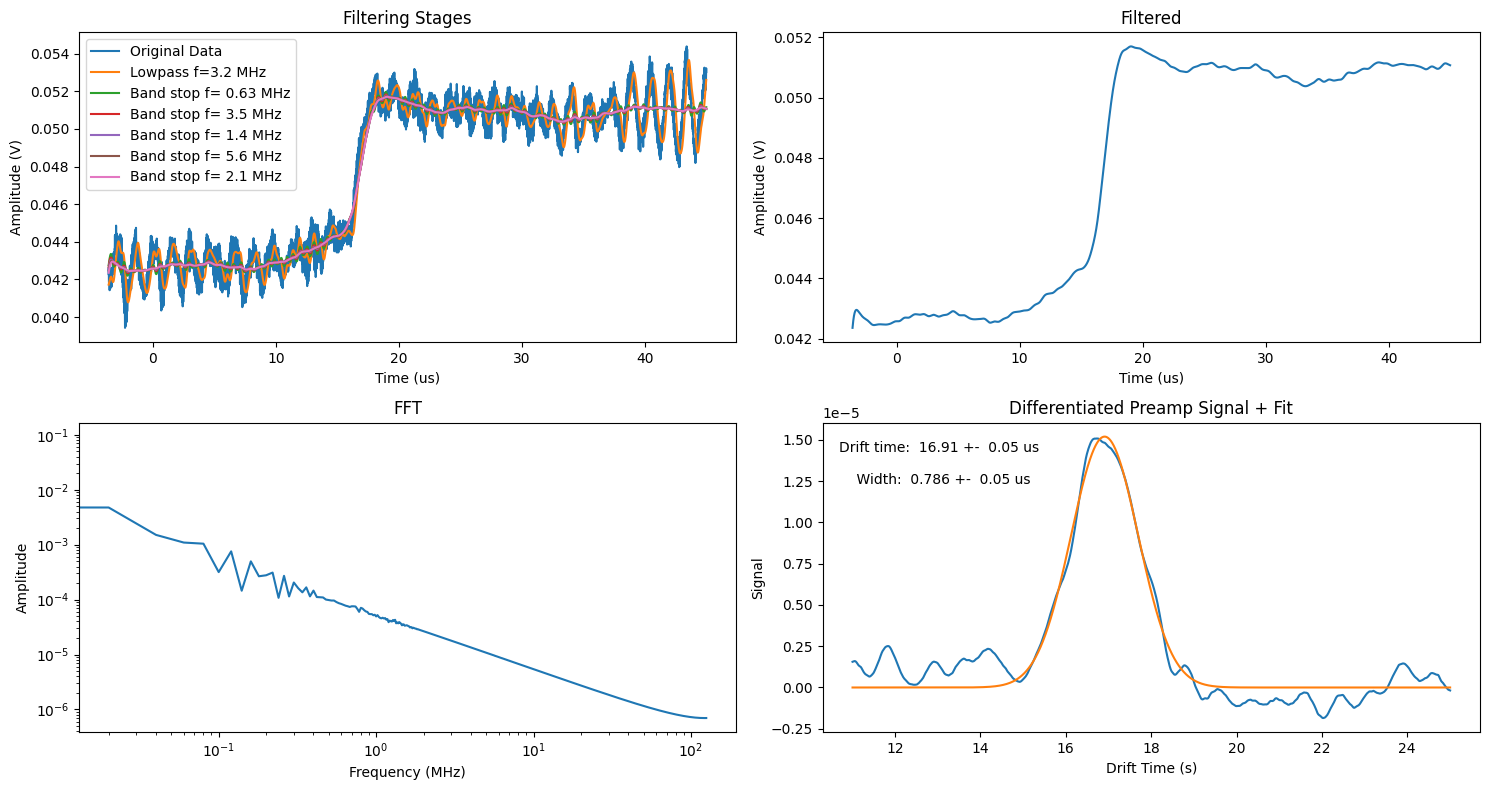

In [30]:
st = 350  # beginning behaves weird
time_us = time * 1e6

fig, axs = plt.subplots(2, 2)


# axs[0, 0].plot(time_us[st:], data[st:], label="Original Data")
# axs[0, 0].plot(time_us[st:], data_filter[st:], label="Low pass")
# axs[0, 0].plot(time_us[st:], data_filter2[st:], label="Bandstop 1")
# axs[0, 0].plot(time_us[st:], data_filter3[st:], label="Bandstop 2")

axs[0, 0].plot(time_us[st:], data[st:], label="Original Data")
data_filtered = data
for label, filt in zip(labels, filters):

    data_filtered = filt(data_filtered)
    axs[0, 0].plot(time_us[st:], data_filtered[st:], label=label)

axs[0, 0].set_xlabel("Time (us)")
axs[0, 0].set_ylabel("Amplitude (V)")
axs[0, 0].set_title("Filtering Stages")
axs[0, 0].legend()


axs[0, 1].plot(time_us[st:], data_filtered[st:])
axs[0, 1].set_title("Filtered")
axs[0, 1].set_xlabel("Time (us)")
axs[0, 1].set_ylabel("Amplitude (V)")

dfft = getFFT(time[st:], data_filtered[st:])


N = len(time)
T = ((time[-1] - time[0])) / N

# FFT
fmin = 0.1
fmax = 0.5
xf = fftfreq(N, T)[: N // 2]  # only used for correct scale when plotting
axs[1, 0].set_xscale("log")
axs[1, 0].set_yscale("log")
axs[1, 0].plot(xf * 1e-6, 2.0 / N * np.abs(dfft[0 : N // 2]))
axs[1, 0].set_title("FFT")
axs[1, 0].set_xlabel("Frequency (MHz)")
axs[1, 0].set_ylabel("Amplitude")

# axs[1, 0].set_xlim(fmin, fmax)


grd = np.gradient(data_filtered)
st = 4000
end = -5000

pp, cov = curve_fit(gauss, time, grd, p0=(1.5e-5, 1.7e-5, 0.2e-5))
# print(pp)
errs = np.sqrt(np.diag(cov))
print(errs)
print(f"{pp[2]*1e6 : .4g} u +- {errs[2]*1e6 : .6g}")
print(f"{pp[1]*1e6 : .4g} us +- {errs[1]*1e6 : .6g}")
print()
axs[1, 1].plot(time_us[st:end], grd[st:end])
axs[1, 1].plot(time_us[st:end], gauss(time[st:end], *pp))
axs[1, 1].set_xlabel(r"Drift Time (s)")
axs[1, 1].set_ylabel("Signal")
axs[1, 1].annotate(
    f"""Drift time: {pp[1]*1e6 : .4g} +- {errs[1] * 1e6 : .1g} us
    
    Width: {pp[2]*1e6 : .3g} +- {errs[2] * 1e6 : .1g} us""",
    (0.025, 0.8),
    xycoords="axes fraction",
    ha="left",
)
# axs[1, 1].annotate(f"Width: {pp[2]*1e6 : .3g} +- {errs[2] * 1e6 : .1g} us", (11, 0.8e-5))
axs[1, 1].set_title("Differentiated Preamp Signal + Fit")

fig.set_figheight(8)
fig.set_figwidth(15)
plt.tight_layout()
plt.show()

In [203]:
from scipy.stats import norm
from scipy.optimize import curve_fit

[8.17400576e-06 4.96464443e-07 4.96464438e-07]
 0.7898 u +-  0.496464
 16.75 us +-  0.496464



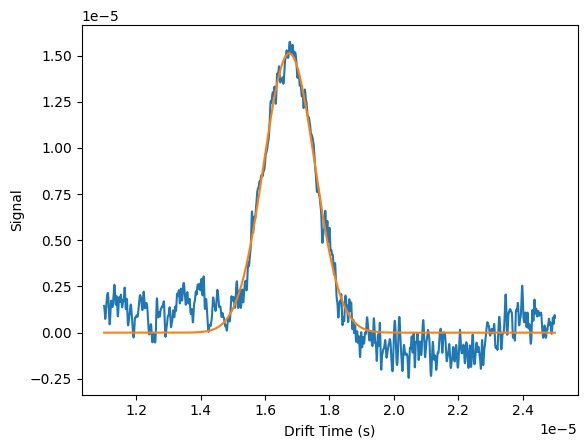

In [131]:
grd = np.gradient(data_filter4)
st = 4000
end = -5000

pp, cov = curve_fit(gauss, time, grd, p0=(1.5e-5, 1.7e-5, 0.2e-5))
# print(pp)
errs = np.sqrt(np.diag(cov))
print(errs)
print(f"{pp[2]*1e6 : .4g} u +- {errs[2]*1e6 : .6g}")
print(f"{pp[1]*1e6 : .4g} us +- {errs[1]*1e6 : .6g}")
print()
plt.plot(time[st:end], grd[st:end])
plt.plot(time[st:end], gauss(time[st:end], *pp))
plt.xlabel(r"Drift Time (s)")
plt.ylabel("Signal")


plt.show()